In [1]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor as LOF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from chinese_calendar import is_workday
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples
import copy
import socket
import struct
import time
import statistics
pd.set_option('mode.chained_assignment', None)

In [2]:
dfinit = pd.read_csv("data/loginmysql-db_for_exp.csv")
dfinit['No.'] = ""
for i in range(dfinit.shape[0]):
    dfinit.loc[i,'No.']=i

groups_sip_dip = dfinit.groupby(['sip','dip'])
groups_sip_dip_sum = pd.DataFrame(dfinit.groupby(['sip','dip'])['num'].sum())
groups_sip_dip_sqlsum = pd.DataFrame(dfinit.groupby(['sip','dip'])['sqlnum'].sum())

dfdict = {}
i = 0
for (k1,k2),groupi in groups_sip_dip:
    dfexpi_sip_dip = groupi
    dfexpi_sip_dip['numSum'] = groups_sip_dip_sum['num'][i]
    dfexpi_sip_dip['sqlnumSum'] = groups_sip_dip_sqlsum['sqlnum'][i]
    dfdict[i] = dfexpi_sip_dip
    i+=1
    
dfdict_pd = pd.concat(list(dfdict.values()), ignore_index=True)

df = copy.deepcopy(dfdict_pd)

for i in range(df.shape[0]):
    df.loc[i,'sip'] = socket.ntohl(struct.unpack("I",socket.inet_aton(str(df.loc[i,'sip'])))[0])
    df.loc[i,'dip'] = socket.ntohl(struct.unpack("I",socket.inet_aton(str(df.loc[i,'dip'])))[0])

df['tih'] = pd.to_datetime(df['tih'], format='%Y-%m-%d')
df['hour']=df['tih'].dt.hour

df.head()


,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,numSum,sqlnumSum,hour
0,2019-05-31 00:00:00,171018619,171040675,1,1,1,1,1,0,0,0,4,93,33,0
1,2019-05-31 01:00:00,171018619,171040675,1,1,1,1,1,0,0,0,9,93,33,1
2,2019-05-31 02:00:00,171018619,171040675,1,1,1,1,1,0,0,0,13,93,33,2
3,2019-05-31 03:00:00,171018619,171040675,1,1,1,1,1,0,0,0,18,93,33,3
4,2019-05-31 04:00:00,171018619,171040675,1,1,1,1,1,0,0,0,22,93,33,4


In [3]:
min_max_scaler_01 = preprocessing.MinMaxScaler(feature_range=(1,10), copy=True)

mmfeature=[x for x in df.columns if x not in ['tih', 'No.','dbtype']]

for col in df[mmfeature]:
    df[[col]]=min_max_scaler_01.fit_transform(df[[col]])
df = df.loc[:, (df != 0).any(axis=0)]
df.head()

,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,numSum,sqlnumSum,hour
0,2019-05-31 00:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,4,1.000364,1.000122,1.000000
1,2019-05-31 01:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,9,1.000364,1.000122,1.391304
2,2019-05-31 02:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,13,1.000364,1.000122,1.782609
3,2019-05-31 03:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,18,1.000364,1.000122,2.173913
4,2019-05-31 04:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,22,1.000364,1.000122,2.565217


In [4]:
df[mmfeature].shape[1]

12

## Kmeans

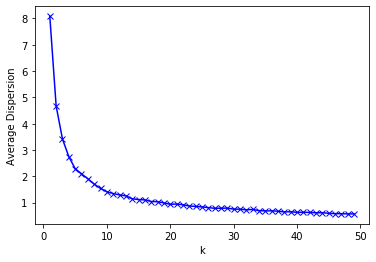

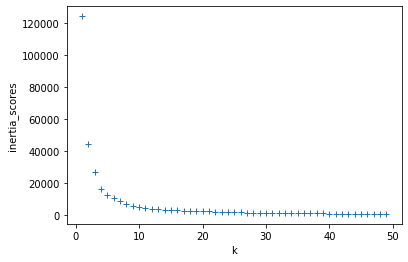

In [5]:
dfexp = copy.deepcopy(df[mmfeature])
K = range(1, 50)
meandistortions = []
inertia_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dfexp)
    meandistortions.append(sum(np.min(cdist(dfexp, kmeans.cluster_centers_, 'euclidean'), axis=1))/dfexp.shape[0])
    inertia_scores.append(kmeans.inertia_)

plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.show()

plt.plot(K, inertia_scores, '+')
plt.xlabel('k')
plt.ylabel('inertia_scores')
plt.show()

In [10]:
#####According to the elbow method take K=20
K=20

# Calculate the distance of each data point to its cluster center
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [14]:
time_start = time.time()

distance = getDistanceByPoint(df[mmfeature], KMeans(n_clusters=K,init="k-means++").fit(df[mmfeature]))#, init = 'random'
df['Distance'] = distance

#### ！Important sort_values
df.sort_values(by="No." , inplace=True, ascending=True)
#### ！Important reset_index
df.reset_index(drop=True, inplace=True)

dfinit['Distance'] = df['Distance']
final = copy.deepcopy(dfinit)
finalsort = final.sort_values(["Distance"],ascending=False)
finalsort.reset_index(drop=True, inplace=True)

time_end = time.time()
cost = round((time_end - time_start),4)

finalsort.head()

,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,Distance
0,2019-06-12 20,10.56.115.125,10.30.245.12,0,0,0,0,0,3,1,db,1629,9.304967
1,2019-06-06 23,10.56.92.187,10.24.249.104,12826,12826,12826,1,1,25645,10,db,840,9.009180
2,2019-05-30 23,10.56.92.187,10.24.249.104,940,940,940,1,1,0,0,0,3,6.647586
3,2019-06-10 23,10.56.92.187,10.24.249.104,1189,1024,1024,1,1,3690,9,db,1242,6.597494
4,2019-05-31 00,10.56.148.238,10.49.21.125,687,687,687,1,1,0,0,0,7,5.713029


In [15]:
print(cost)

1.4569


### For ROC&PR

In [16]:
#############Defining Parameters and Functions#############
IPnumlist = pd.concat([dfinit["sip"], dfinit["dip"]], axis=0)
IPnumlist=IPnumlist.drop_duplicates()
IPnumlist.reset_index(drop=True, inplace=True)
IPnum= IPnumlist.shape[0]

dfabcorrect=['10.49.223.194','10.49.212.206','10.49.141.206','10.56.34.134','10.49.253.35',
             '10.49.179.13','10.56.148.80',
             '10.32.240.119','10.49.21.125','10.56.148.238']    
def Metric(abIP,TP,FN):
    FP=abIP-TP
    TN=IPnum-abIP-FN
    
    R= TP/(TP+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(TN+FP)
    P=TP/(TP+FP)
    return round(R, 4),round(TPR, 4),round(FPR, 4),round(P, 4)

TPRlist = []
FPRlist = []
Plist = []
Rlist = []

num=1
while num < finalsort.shape[0]+1:
    ab_finalsort= finalsort[0:num]
    num += 1
    dfabip=pd.concat([ab_finalsort["sip"], ab_finalsort["dip"]], axis=0)
    dfabip=dfabip.drop_duplicates()
    dfabip.reset_index(drop=True, inplace=True)

    dfabip.tolist()
    dfabip_set = set(dfabip)

    dfabcorrect_set = set(dfabcorrect)
    bingo=(dfabip_set)&(dfabcorrect_set)

    abIPi=len(dfabip)
    TPi=len(bingo)
    FNi=len(dfabcorrect)-TPi
    
    R,TPR,FPR,P = Metric(abIPi,TPi,FNi)
    TPRlist.append(TPR)
    FPRlist.append(FPR)
    Plist.append(P)
    Rlist.append(R)
    
ROC = pd.DataFrame(FPRlist, columns=['FPR'])
ROC = pd.concat([ROC, pd.DataFrame(TPRlist,columns=['TPR'])],axis=1)
PR = pd.DataFrame(Rlist, columns=['R'])
PR = pd.concat([PR, pd.DataFrame(Plist,columns=['P'])],axis=1)

####Importance drop_duplicates
ROC=ROC.drop_duplicates()
PR=PR.drop_duplicates()

####Importance sort_values
ROC.sort_values(by=['FPR','TPR'],inplace=True,ascending=True)
PR.sort_values(by=['R','P'],inplace=True,ascending=True)
ROC.reset_index(drop=True, inplace=True)
PR.reset_index(drop=True, inplace=True)
# PR

#####Importance Add the last line For ROC
ROC.loc[ROC.shape[0]] = [1,ROC.loc[ROC.shape[0]-1,'TPR']]
#####Importance Add the first line For PR
PR.loc[-1] = [0,PR.loc[0,'P']]
PR.index = PR.index + 1
PR.sort_index(inplace=True)

#####AUC
ROC_AUC = np.trapz(list(ROC['TPR']),list(ROC['FPR'])).round(4)
PRC_AUC = np.trapz(list(PR['P']),list(PR['R'])).round(4)

print(ROC_AUC,PRC_AUC,cost)

0.332 0.2008 1.4569


## DBSCAN

### Test

In [17]:
###Selecting parameters iteratively
MIN_Samples = 5
EPS = 0.5

# Constructs an empty list to hold the results for different combinations of parameters
res = []
dbscan = DBSCAN(eps = EPS, min_samples = MIN_Samples)
df['clusters']=dbscan.fit_predict(df[mmfeature])

#### ！Important sort_values
df.sort_values(by="No." , inplace=True, ascending=True)
#### ！Important reset_index
df.reset_index(drop=True, inplace=True)

dfinit['clusters'] = df['clusters']
dfinit.head()


,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,Distance,clusters
0,2019-05-30 23,10.49.148.130,10.49.148.131,487,487,487,1,1,0,0,0,0,3.773583,-1
1,2019-05-30 23,10.49.178.162,10.49.174.157,4,4,4,1,1,0,0,0,1,1.316508,0
2,2019-05-30 23,10.56.148.238,10.49.21.125,159,159,159,1,1,0,0,0,2,3.353524,-1
3,2019-05-30 23,10.56.92.187,10.24.249.104,940,940,940,1,1,0,0,0,3,6.647586,-1
4,2019-05-31 00,10.49.137.123,10.49.223.163,1,1,1,1,1,0,0,0,4,0.969637,0


In [18]:
dfinit['clusters'].value_counts()

 0     790
-1     251
 1      91
 2      88
 3      69
 14     48
 10     44
 4      36
 11     29
 15     28
 16     21
 13     18
 12     17
 7      15
 8      14
 20     12
 25      7
 18      7
 17      5
 22      5
 9       5
 6       5
 5       5
 19      5
 21      5
 24      5
 23      5
Name: clusters, dtype: int64

In [19]:
####Take -1 as the outlier
dfab = dfinit[dfinit['clusters'] == -1]
dfab.reset_index(drop=True, inplace=True)
dfab.head()

,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,Distance,clusters
0,2019-05-30 23,10.49.148.130,10.49.148.131,487,487,487,1,1,0,0,0,0,3.773583,-1
1,2019-05-30 23,10.56.148.238,10.49.21.125,159,159,159,1,1,0,0,0,2,3.353524,-1
2,2019-05-30 23,10.56.92.187,10.24.249.104,940,940,940,1,1,0,0,0,3,6.647586,-1
3,2019-05-31 00,10.56.148.238,10.49.21.125,687,687,687,1,1,0,0,0,7,5.713029,-1
4,2019-05-31 02,10.49.231.21,10.49.253.35,6549,6449,6549,1,1,0,0,0,16,0.584847,-1


### BatchTest For ROC&PR

In [55]:
IPnumlist = pd.concat([dfinit["sip"], dfinit["dip"]], axis=0)
IPnumlist=IPnumlist.drop_duplicates()
IPnumlist.reset_index(drop=True, inplace=True)
IPnum= IPnumlist.shape[0]

dfabcorrect=['10.49.223.194','10.49.212.206','10.49.141.206','10.56.34.134','10.49.253.35',
             '10.49.179.13','10.56.148.80',
             '10.32.240.119','10.49.21.125','10.56.148.238']
    
def Metric(abIP,TP,FN):
    FP=abIP-TP
    TN=IPnum-abIP-FN
    
    R= TP/(TP+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(TN+FP)
    P=TP/(TP+FP)
    return round(R, 4),round(TPR, 4),round(FPR, 4),round(P, 4)

costlist = []
TPRlist = []
FPRlist = []
Plist = []
Rlist = []
########### Obtain different ROC and PR values by iterating over the parameters
for EPS in np.arange(0.01,1,0.02):
    for MIN_Samples in np.arange(2,150,5):

        time_start = time.time()
        
        dbscan = DBSCAN(eps = EPS, min_samples = MIN_Samples)
        df['clusters']=dbscan.fit_predict(df[mmfeature])
        
        #### ！Important sort_values
        df.sort_values(by="No." , inplace=True, ascending=True)
        #### ！Important reset_index
        df.reset_index(drop=True, inplace=True)
        dfinit['clusters'] = df['clusters']
        ####Take -1 as the outlier
        dfab = dfinit[dfinit['clusters'] == -1]
        dfab.reset_index(drop=True, inplace=True)
        
        time_end = time.time()
        
        cost = round((time_end - time_start),4)
        costlist.append(cost)
        
        
        dfabip=pd.concat([dfab["sip"], dfab["dip"]], axis=0)
        dfabip=dfabip.drop_duplicates()
        dfabip.reset_index(drop=True, inplace=True)
        
        if(dfabip.shape[0]==0):
            continue
                
        dfabip.tolist()
        dfabip_set = set(dfabip)

        dfabcorrect_set = set(dfabcorrect)
        bingo=(dfabip_set)&(dfabcorrect_set)

        abIPi=len(dfabip)
        TPi=len(bingo)
        FNi=len(dfabcorrect)-TPi

        R,TPR,FPR,P = Metric(abIPi,TPi,FNi)
        TPRlist.append(TPR)
        FPRlist.append(FPR)
        Plist.append(P)
        Rlist.append(R)

ROC = pd.DataFrame(FPRlist, columns=['FPR'])
ROC = pd.concat([ROC, pd.DataFrame(TPRlist,columns=['TPR'])],axis=1)
PR = pd.DataFrame(Rlist, columns=['R'])
PR = pd.concat([PR, pd.DataFrame(Plist,columns=['P'])],axis=1)

        
####Importance drop_duplicates
ROC=ROC.drop_duplicates()
PR=PR.drop_duplicates()

####Importance sort_values
ROC.sort_values(by=['FPR','TPR'],inplace=True,ascending=True)
PR.sort_values(by=['R','P'],inplace=True,ascending=True)
ROC.reset_index(drop=True, inplace=True)
PR.reset_index(drop=True, inplace=True)
# PR

#####Importance Add the last line For ROC
ROC.loc[ROC.shape[0]] = [1,ROC.loc[ROC.shape[0]-1,'TPR']]
#####Importance Add the first line For PR
PR.loc[-1] = [0,PR.loc[0,'P']]
PR.index = PR.index + 1
PR.sort_index(inplace=True)

#####AUC
ROC_AUC = np.trapz(list(ROC['TPR']),list(ROC['FPR'])).round(4)
PRC_AUC = np.trapz(list(PR['P']),list(PR['R'])).round(4)

print(ROC_AUC,PRC_AUC,statistics.mean(costlist))

0.306 0.2315 0.026685666666666667


## IForest For ROC&PR

In [32]:
rng = np.random.RandomState(13)

# iForestDf = copy.deepcopy(df[mmfeature])
iForestDf = copy.deepcopy(df)
iForestDf.head()

# model_isof = IsolationForest(n_estimators = 100,max_samples = 200, random_state=rng, contamination = 0.2)
# outlier_label = model_isof.fit_predict(iForestDf[mmfeature])
# outlier_pd = pd.DataFrame(outlier_label, columns=['outlier_label'])
# iForestDf['outlier_label'] = outlier_label
# iForestDf

,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,numSum,sqlnumSum,hour,Distance,clusters
0,2019-05-30 23:00:00,1.054395,9.851963,1.341728,1.341728,1.341728,10.0,4.0,1.0,1.0,0,0,5.716754,6.301649,10.0,3.773583,-1
1,2019-05-30 23:00:00,1.201123,9.888643,1.002807,1.002807,1.002807,10.0,4.0,1.0,1.0,0,1,1.029164,1.003329,10.0,1.316508,0
2,2019-05-30 23:00:00,9.784645,9.673461,1.111570,1.111570,1.111570,10.0,4.0,1.0,1.0,0,2,1.003340,1.000000,10.0,3.353524,-1
3,2019-05-30 23:00:00,9.510919,1.000000,1.659598,1.659598,1.659598,10.0,4.0,1.0,1.0,0,3,10.000000,10.000000,10.0,6.647586,-1
4,2019-05-31 00:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,4,1.000364,1.000122,1.0,0.969637,-1


In [33]:
IPnumlist = pd.concat([dfinit["sip"], dfinit["dip"]], axis=0)
IPnumlist=IPnumlist.drop_duplicates()
IPnumlist.reset_index(drop=True, inplace=True)
IPnum= IPnumlist.shape[0]

dfabcorrect=['10.49.223.194','10.49.212.206','10.49.141.206','10.56.34.134','10.49.253.35',
             '10.49.179.13','10.56.148.80',
             '10.32.240.119','10.49.21.125','10.56.148.238']
    
def Metric(abIP,TP,FN):
    FP=abIP-TP
    TN=IPnum-abIP-FN
    
    R= TP/(TP+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(TN+FP)
    P=TP/(TP+FP)
    return round(R, 4),round(TPR, 4),round(FPR, 4),round(P, 4)

TPRlist = []
FPRlist = []
Plist = []
Rlist = []
costlist_iforest = []

for Contamination in np.arange(0.01,0.5,0.05):
    for Max_samples in np.arange(10,300,50):
        for N_estimators in np.arange(40,200,30):
            
            time_start = time.time()
            
            model_isof = IsolationForest(behaviour="new",n_estimators = N_estimators,max_samples = Max_samples, random_state=rng, contamination = Contamination)
            outlier_label = model_isof.fit_predict(iForestDf[mmfeature])
            outlier_pd = pd.DataFrame(outlier_label, columns=['outlier_label_iForest'])
            iForestDf['outlier_label_iForest'] = outlier_label
            #### ！Important sort_values
            iForestDf.sort_values(by="No." , inplace=True, ascending=True)
            #### ！Important reset_index
            iForestDf.reset_index(drop=True, inplace=True)
            dfinit['outlier_label_iForest'] = iForestDf['outlier_label_iForest']

            ####Take -1 as the outlier
            dfab = dfinit[dfinit['outlier_label_iForest'] == -1]
            dfab.reset_index(drop=True, inplace=True)

            time_end = time.time()
            cost = round((time_end - time_start),4)
            costlist_iforest.append(cost)
            
            dfabip=pd.concat([dfab["sip"], dfab["dip"]], axis=0)
            dfabip=dfabip.drop_duplicates()
            dfabip.reset_index(drop=True, inplace=True)

            if(dfabip.shape[0]==0):
                continue

            dfabip.tolist()
            dfabip_set = set(dfabip)

            dfabcorrect_set = set(dfabcorrect)
            bingo=(dfabip_set)&(dfabcorrect_set)

            abIPi=len(dfabip)
            TPi=len(bingo)
            FNi=len(dfabcorrect)-TPi

            R,TPR,FPR,P = Metric(abIPi,TPi,FNi)
            TPRlist.append(TPR)
            FPRlist.append(FPR)
            Plist.append(P)
            Rlist.append(R)

ROC = pd.DataFrame(FPRlist, columns=['FPR'])
ROC = pd.concat([ROC, pd.DataFrame(TPRlist,columns=['TPR'])],axis=1)
PR = pd.DataFrame(Rlist, columns=['R'])
PR = pd.concat([PR, pd.DataFrame(Plist,columns=['P'])],axis=1)
     
####Importance drop_duplicates
ROC=ROC.drop_duplicates()
PR=PR.drop_duplicates()

####Importance sort_values
ROC.sort_values(by=['FPR','TPR'],inplace=True,ascending=True)
PR.sort_values(by=['R','P'],inplace=True,ascending=True)
        
ROC.reset_index(drop=True, inplace=True)
PR.reset_index(drop=True, inplace=True)

#####Importance Add the last line For ROC
ROC.loc[ROC.shape[0]] = [1,ROC.loc[ROC.shape[0]-1,'TPR']]
#####Importance Add the first line For PR
PR.loc[-1] = [0,PR.loc[0,'P']]
PR.index = PR.index + 1
PR.sort_index(inplace=True)

#####AUC
ROC_AUC = np.trapz(list(ROC['TPR']),list(ROC['FPR'])).round(4)
PRC_AUC = np.trapz(list(PR['P']),list(PR['R'])).round(4)

print(ROC_AUC,PRC_AUC,statistics.mean(costlist_iforest))

0.344 0.1207 0.2891813888888889


## LOF For ROC&PR

In [35]:
LOFDf = copy.deepcopy(df)
LOFDf.head()

,tih,sip,dip,num,difsport,difpw,difinfo,difuser,sqlnum,difsqlinfo,dbtype,No.,numSum,sqlnumSum,hour,Distance,clusters
0,2019-05-30 23:00:00,1.054395,9.851963,1.341728,1.341728,1.341728,10.0,4.0,1.0,1.0,0,0,5.716754,6.301649,10.0,3.773583,-1
1,2019-05-30 23:00:00,1.201123,9.888643,1.002807,1.002807,1.002807,10.0,4.0,1.0,1.0,0,1,1.029164,1.003329,10.0,1.316508,0
2,2019-05-30 23:00:00,9.784645,9.673461,1.111570,1.111570,1.111570,10.0,4.0,1.0,1.0,0,2,1.003340,1.000000,10.0,3.353524,-1
3,2019-05-30 23:00:00,9.510919,1.000000,1.659598,1.659598,1.659598,10.0,4.0,1.0,1.0,0,3,10.000000,10.000000,10.0,6.647586,-1
4,2019-05-31 00:00:00,1.000685,9.957534,1.000702,1.000702,1.000702,10.0,4.0,1.0,1.0,0,4,1.000364,1.000122,1.0,0.969637,-1


In [36]:
IPnumlist = pd.concat([dfinit["sip"], dfinit["dip"]], axis=0)
IPnumlist=IPnumlist.drop_duplicates()
IPnumlist.reset_index(drop=True, inplace=True)
IPnum= IPnumlist.shape[0]
dfabcorrect=['10.49.223.194','10.49.212.206','10.49.141.206','10.56.34.134','10.49.253.35',
             '10.49.179.13','10.56.148.80',
             '10.32.240.119','10.49.21.125','10.56.148.238']
    
def Metric(abIP,TP,FN):
    FP=abIP-TP
    TN=IPnum-abIP-FN
    
    R= TP/(TP+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(TN+FP)
    P=TP/(TP+FP)
    return round(R, 4),round(TPR, 4),round(FPR, 4),round(P, 4)

TPRlist = []
FPRlist = []
Plist = []
Rlist = []
costlist_lof=[]
for N_neighbors in np.arange(10,400,10):
    for Contamination in np.arange(0.01,0.5,0.05):
#     for N_neighbors in np.arange(10,300,10):
        
        time_start = time.time()
        model_lof = LOF(n_neighbors=N_neighbors,contamination=Contamination)
        outlier_label = model_lof.fit_predict(LOFDf[mmfeature])
        outlier_pd = pd.DataFrame(outlier_label, columns=['outlier_label_LOF'])
        LOFDf['outlier_label_LOF'] = outlier_label
        #### ！Important sort_values
        LOFDf.sort_values(by="No." , inplace=True, ascending=True)
        #### ！Important reset_index
        LOFDf.reset_index(drop=True, inplace=True)
        dfinit['outlier_label_LOF'] = LOFDf['outlier_label_LOF']

        ####Take -1 as the outlier
        dfab = dfinit[dfinit['outlier_label_LOF'] == -1]
        dfab.reset_index(drop=True, inplace=True)
        
        time_end = time.time()
        cost = round((time_end - time_start),4)
        costlist_lof.append(cost)

        dfabip=pd.concat([dfab["sip"], dfab["dip"]], axis=0)
        dfabip=dfabip.drop_duplicates()
        dfabip.reset_index(drop=True, inplace=True)

        if(dfabip.shape[0]==0):
            continue

        dfabip.tolist()
        dfabip_set = set(dfabip)

        dfabcorrect_set = set(dfabcorrect)
        bingo=(dfabip_set)&(dfabcorrect_set)

        abIPi=len(dfabip)
        TPi=len(bingo)
        FNi=len(dfabcorrect)-TPi

        R,TPR,FPR,P = Metric(abIPi,TPi,FNi)
        TPRlist.append(TPR)
        FPRlist.append(FPR)
        Plist.append(P)
        Rlist.append(R)

ROC = pd.DataFrame(FPRlist, columns=['FPR'])
ROC = pd.concat([ROC, pd.DataFrame(TPRlist,columns=['TPR'])],axis=1)
PR = pd.DataFrame(Rlist, columns=['R'])
PR = pd.concat([PR, pd.DataFrame(Plist,columns=['P'])],axis=1)
     
####Importance drop_duplicates
ROC=ROC.drop_duplicates()
PR=PR.drop_duplicates()

####Importance sort_values
ROC.sort_values(by=['FPR','TPR'],inplace=True,ascending=True)
PR.sort_values(by=['R','P'],inplace=True,ascending=True)
        
ROC.reset_index(drop=True, inplace=True)
PR.reset_index(drop=True, inplace=True)
#####Importance Add the last line For ROC
ROC.loc[ROC.shape[0]] = [1,ROC.loc[ROC.shape[0]-1,'TPR']]
#####Importance Add the first line For PR
PR.loc[-1] = [0,PR.loc[0,'P']]
PR.index = PR.index + 1
PR.sort_index(inplace=True)

#####AUC
ROC_AUC = np.trapz(list(ROC['TPR']),list(ROC['FPR'])).round(4)
PRC_AUC = np.trapz(list(PR['P']),list(PR['R'])).round(4)

print(ROC_AUC,PRC_AUC,statistics.mean(costlist_lof))

0.384 0.2423 0.07114435897435897


In [99]:
# ROC.to_csv("Results/LOF_ROC_Lab-1.csv",index=0)
# PR.to_csv("Results/LOF_PR_Lab-1.csv",index=0)